In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from pythonlib.tools.stroketools import *
from drawmonkey.tools.preprocess import *
from sklearn.linear_model import LinearRegression
from pyvm.classes.videoclass import Videos

from drawmonkey.tools.handtrack import HandTrack, getTrialsCameraFrametimes
from pyvm.utils.directories import get_metadata
from pythonlib.tools.expttools import load_yaml_config
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pythonlib.tools.stroketools import strokesInterpolate2
from pyvm.globals import BASEDIR, NCAMS

ncams = 4
SAVEDIR = "/data3/hand_track/Pancho"

In [19]:
date = 221015
expt = "dircolor1"
sess = 1
sess_print = "1"
animal = "Pancho"

trial_ml2 = 36
ind1_vid = 0
ind1_ml2 = 1

fd = loadSingleDataQuick(animal, date, expt, sess)
HT = HandTrack(ind1_vid, ind1_ml2, fd, date=date, expt=expt)
# HT.load_campy_data(ind1_ml2, sess=sess_print)

/home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/221015/221015_*_dircolor1_Pancho_1.pkl
/home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/221015/221015_*_dircolor1_Pancho_1.pkl
-- loaded presaved data: /home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/221015/221015_140751_dircolor1_Pancho_1.pkl


In [20]:
from drawmonkey.tools.utils import getTrialsAnalogData
chan = "Btn1"
thresh = 0.5

# frames
dat_frames = getTrialsAnalogData(fd, trial_ml2, chan)

# take analog input (frametimes) and convert to ons and offs
# -- Statitsics of frame data
# get crossings
v = dat_frames[:,0] # voltage
t = dat_frames[:,1]

# should already be thresholded, by do this anyway so that no numerical errors.

v[v>=thresh] = 1
v[v<thresh] = 0
vdiff = np.diff(v)

# Get onsets, offsets
ons = np.where(vdiff==1)[0]+1 # plus 1, sinec want first frame of new state.
offs = np.where(vdiff==-1)[0]+1

#If shifted by one assume that there is just an onset or offset error in the beginning
size_diff = len(offs) - len(ons)
if size_diff == 1:
    offs = offs[1:len(offs)]
elif size_diff == -1:
    ons = ons[0:len(ons)-1]
else: 
    assert len(ons)==len(offs), f"ONS:{len(ons)}, OFFS:{len(offs)},clipped? Wrong day data?"

# Convert from indices to times.
ons_sec = t[ons]
offs_sec = t[offs]

beh_ts = ons_sec


In [14]:
volt_t_list = []
for trial in [trial_ml2 -1, trial_ml2, trial_ml2+1]:
    t_intrial = getTrialsCameraFrametimes(fd, trial)[0]
    t_intrial_z = [t - t_intrial[0] for t in t_intrial]
    volt_t_list.append(t_intrial_z)

In [21]:
df_campy = HT.load_campy_data(trial_ml2, fail_if_skip=True, 
            return_empty_if_skip=True)
frametimes_mean = np.mean(np.stack(df_campy["campy_frametimes"]), 0)
frametimes_mean_z = [t - frametimes_mean[0] for t in frametimes_mean]

campy_times = frametimes_mean_z
volt_times = t_intrial_z

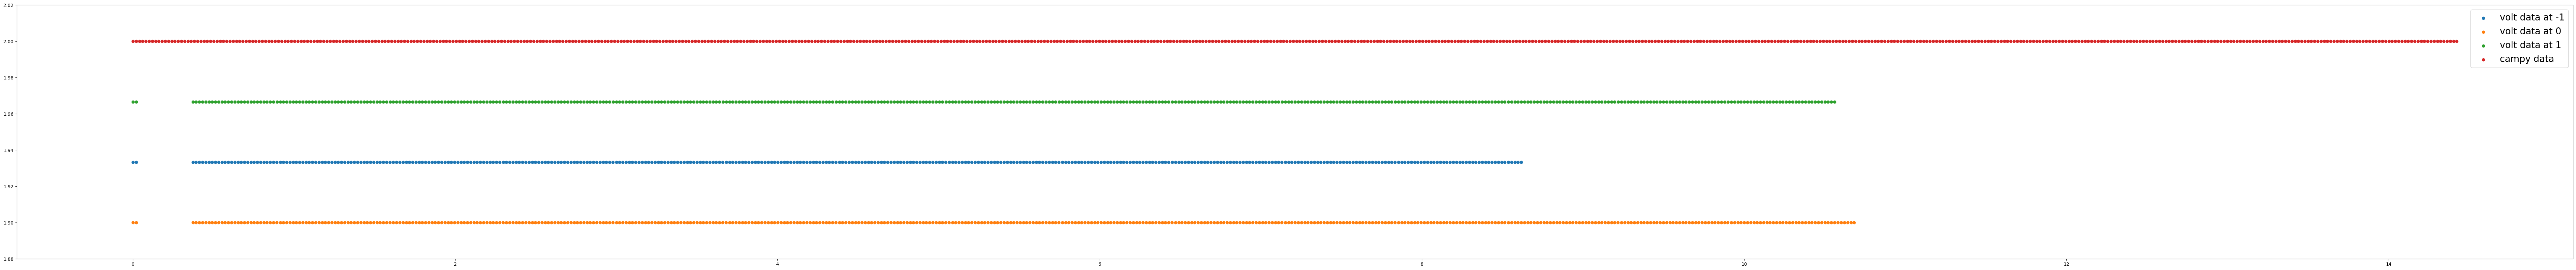

In [22]:
# volt_t_heights = [1.9,1.92,1.94,1.96,1.98]
volt_t_heights = [1.93333,1.9,1.966667]
volt_ys = []
for volt_dat, y in zip (volt_t_list, volt_t_heights):
    volt_ys.append([y for t in volt_dat])
campy_ys = [2 for t in campy_times]
plt.figure(figsize=(100,10))
for i, volt_dat in enumerate(volt_t_list):
    plt.scatter(x=volt_dat, y=volt_ys[i], label=f"volt data at {i-1}")
plt.scatter(x=campy_times,y=campy_ys,label="campy data")

plt.ylim((1.88,2.02))

plt.legend(prop={'size':20})
plt.show()


In [24]:
print(frametimes_mean)

[479.95614367 479.97620227 479.99625805 480.01631868 480.03637935
 480.05644008 480.07649239 480.096551   480.11661058 480.13667795
 480.15673354 480.17679061 480.1968428  480.21689869 480.23695731
 480.25700958 480.27706664 480.29712267 480.31717463 480.33722971
 480.35729419 480.37736023 480.39741901 480.41747115 480.43752884
 480.45758946 480.47765026 480.49770231 480.51776102 480.5378218
 480.55788243 480.57794667 480.5979989  480.61805658 480.63811174
 480.65816388 480.67822272 480.69828039 480.71834098 480.73839984
 480.75845209 480.77851272 480.7985702  480.81863083 480.83868958
 480.85874194 480.87880255 480.89886331 480.9189276  480.93897966
 480.95904022 480.97909598 480.99915325 481.01920696 481.03926117
 481.05931983 481.07938419 481.09944688 481.11950543 481.13955758
 481.1596184  481.17967886 481.19974326 481.21980095 481.23985972
 481.25992041 481.279981   481.30003305 481.32008532 481.34014978
 481.3602103  481.38027653 481.40033148 481.42038376 481.44044803
 481.460512

In [17]:
dist_campy = pd.Series(campy_times).diff().mean()
dist_volt = pd.Series(volt_t_list[1])[3:].diff().mean()

print("campy dist:", dist_campy, "campy len", len(campy_ys))
print("volt_dist:", dist_volt, "volt len", len(volt_t_list[1]))

campy dist: 0.02005827246388277 campy len 444
volt_dist: 0.020058479532163744 volt len 517


0        NaN
1      0.020
2      0.352
3      0.020
4      0.020
       ...  
512    0.022
513    0.020
514    0.020
515    0.020
516    0.020
Length: 517, dtype: float64
0.352
2
515
444


ValueError: x and y must be the same size

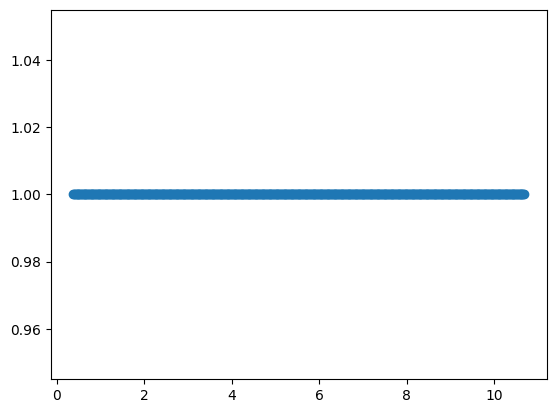

In [18]:
volt_times = pd.Series(volt_t_list[1])

volt_diffs = volt_times.diff()
print(volt_diffs)

volt_max = max([d for d in volt_diffs if str(d) != "nan"])
print(volt_max)
max_ind = 0
for i in range(len(volt_diffs)):
    if str(volt_diffs[i]) != "nan":
        if volt_diffs[i] == volt_max:
            max_ind = i
            break
print(max_ind)

volt_align = volt_times[max_ind:]
volt_ys = [1 for t in volt_align]


cam_align = campy_times[0:len(volt_align)]
cam_ys = [2 for t in volt_align]
print(len(volt_align))
print(len(cam_align))

plt.scatter(x=volt_align, y = volt_ys)
plt.scatter(x=cam_align, y = cam_ys)

In [18]:
dat, _ = HT.process_data_singletrial(4, ploton=False, finger_raise_time=0.0)

TODO: Get accurate frametime after pass in frame extraction to Buttons
Searching using this string:
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/*camera*trial_7-*dat**
Found this many paths:
4
---
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/camera_bfs1_-trial_7-dat.pkl
---
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/camera_flea_-trial_7-dat.pkl
---
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/camera_fly1_-trial_7-dat.pkl
---
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/camera_fly2_-trial_7-dat.pkl
x (476,)
y (476,)
z (476,)
t (476,)
t_trial (476,)
likelihood_min (476,)
500.0
